# Twitch API Request Test
---
Twitch API Docs : [Twitch Developers] (https://dev.twitch.tv/docs/v5) <br>
Twitch API Client : [Twitch Developers Console] (https://dev.twitch.tv/console/apps) <br>
Twitch API Video Obj : [Twitch API Video Reference] (https://dev.twitch.tv/docs/api/reference#get-videos) <br>
Test Live Video : [PAKA 11/03 Broadcast](https://www.twitch.tv/videos/790636820) 

In [27]:
import requests
import json
import sys

In [28]:
videoID = "790636820"
clientID = "k8tbrzzuqt746l6zq8wqdbcad06tb0"

params = dict({"client_id":clientID})

In [29]:
import numpy as np
import pandas as pd

## 1. Get Json From Twitch API , Save As DataFrame
---
DataFrame to CSV : [Pandas Reference] (https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_csv.html) <br>
DataFrame to CSV Encoding : [한글 깨짐 오류 해결] (https://dolhani.tistory.com/521) <br>

In [34]:
chat_log = pd.DataFrame(columns=["Time","User","Chat"])
chat_index = 0

while True:
    if chat_index == 0:
        URL = "https://api.twitch.tv/v5/videos/" + videoID + "/comments?content_offset_seconds=0"
        chat_index += 1
    else:
        URL = "https://api.twitch.tv/v5/videos/" + videoID + "/comments?cursor="
        URL += nextCursor
    
    response = requests.get(URL, params=params)
    data = json.loads(response.text)

    # Make Series
    for idx in range(len(data["comments"])):
        Time = data["comments"][idx]["created_at"][11:19]
        User = data["comments"][idx]["commenter"]["display_name"]
        Chat = data["comments"][idx]["message"]["body"]
        # Append in DataFrame
        log = pd.Series({"Time":Time, "User":User, "Chat":Chat})
        chat_log = chat_log.append(log, ignore_index=True)

    if "_next" not in data.keys():
        break
    nextCursor = data["_next"]

In [35]:
chat_log.to_csv("chat_log.csv", index=False, encoding="utf-8-sig")

## 2. Load Chat Log from CSV
---
Read CSV : [Pandas Reference] (https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) <br>

In [38]:
chat_log = pd.read_csv("chat_log.csv", encoding="utf-8-sig")
chat_log.head()

,Time,User,Chat
0,10:56:27,dododoni,팤하
1,10:56:39,아캅스9999,안녕하세요
2,10:56:49,scsc0385,ㅇㄴ
3,10:56:55,태풍바람토네이도,ㅗ
4,10:56:55,잘생긴김형섭,개카


## 3. Analysis Chat Frequency
---
Python Word Cloud : [KonlpyTwitter, Counter] (https://imworld.tistory.com/59) <br>

In [67]:
from collections import Counter
from konlpy.tag import Twitter

In [68]:
# Merge Chat Log with String and Save as TXT File
with open("chat_string.txt", mode="w", encoding="utf-8-sig") as chat_string:
    chat_content = ""
    for idx, chat in enumerate(chat_log["Chat"]):
        chat_content += chat + '\n'

    chat_string.writelines(chat_content)

In [69]:
# Open Txt File
chat_string = open("chat_string.txt", mode="r", encoding="utf-8-sig")
chat_list = chat_string.readlines()
chat_string.close()

In [81]:
# Analyze Words Morphs (형태소 분석)
twitter = Twitter()
morphs = list()

for sentence in chat_list:
    morphs.append(twitter.pos(sentence))
print(morphs)

oun'), ('의', 'Josa'), ('삶', 'Noun'), ('...', 'Punctuation'), ('\n', 'Foreign')], [('레전드', 'Noun'), ('의', 'Josa'), ('시간', 'Noun'), ('이', 'Josa'), ('다가온다', 'Verb'), ('\n', 'Foreign')], [('똥좀', 'Noun'), ('뿌리', 'Noun'), ('죠', 'Josa'), ('ㅋㅋ', 'KoreanParticle'), ('\n', 'Foreign')], [('일어날', 'Verb'), ('시간', 'Noun'), ('!', 'Punctuation'), ('\n', 'Foreign')], [('2', 'Number'), ('판', 'Noun'), ('하다', 'Verb'), ('꼴', 'Noun'), ('받으면', 'Verb'), ('방종할듯', 'Adjective'), ('\n', 'Foreign')], [('레전드', 'Noun'), ('의', 'Josa'), ('시간', 'Noun'), ('이', 'Josa'), ('다가온다', 'Verb'), ('\n', 'Foreign')], [('올리버', 'Noun'), ('의', 'Josa'), ('삶', 'Noun'), ('이', 'Josa'), ('뭐', 'Noun'), ('에요', 'Josa'), ('?', 'Punctuation'), ('\n', 'Foreign')], [('도', 'Noun'), ('네', 'Suffix'), ('도', 'Josa'), ('없고', 'Adjective'), ('분위기', 'Noun'), ('도', 'Josa'), ('곱창', 'Noun'), ('나', 'Noun'), ('는', 'Josa'), ('시간대', 'Noun'), ('\n', 'Foreign')], [('롤', 'Noun'), ('안', 'VerbPrefix'), ('할듯', 'Verb'), ('\n', 'Foreign')], [('친구', 'Noun'), ('좋다는게', 'A

In [86]:
# Extract Words
extracted_words = list()

for sentence in morphs:
    for word, tag in sentence:
        if ((tag not in "Foreign") or (tag not in "Josa") or (tag not in "Alpha") or (tag not in "KoreanParticle") or (tag not in "Punctuation")) and ('\n' not in word) and (tag in "Adjective"):
            extracted_words.append(word)

In [87]:
count = Counter(extracted_words)
words = dict(count.most_common())

In [88]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords

%matplotlib inline
import matplotlib
from IPython.display import set_matplotlib_formats

matplotlib.rc("font", family="Malgun Gothic")
set_matplotlib_formats("retina")
matplotlib.rc("axes", unicode_minus=False)

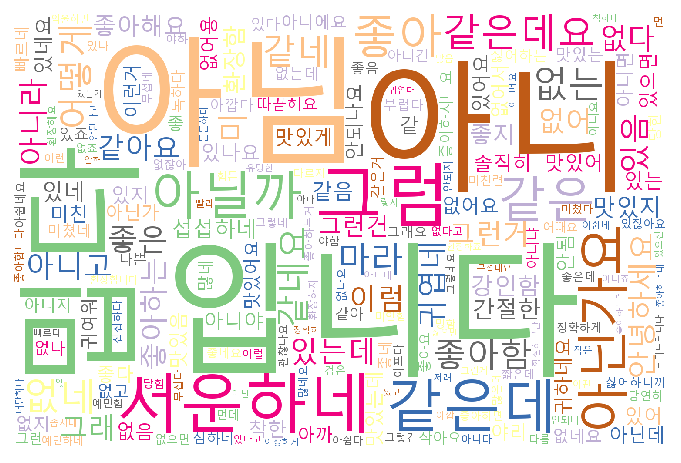

In [89]:
wordcloud = WordCloud(font_path = 'C:/Windows/Fonts/malgun.ttf', background_color='white',colormap = "Accent_r", width=1500, height=1000).generate_from_frequencies(words)

plt.imshow(wordcloud)
plt.axis('off')
plt.show()